<a href="https://colab.research.google.com/github/Akanty/hello-world/blob/main/Drowsiness_Detection_Model_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Connect to google drive

from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import zipfile

# zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset.zip", 'r')
# zip_ref.extractall("/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/training_dataset")
# zip_ref.close()

In [ ]:
# This cell should only be excuted if the combined dataset isnt present as it generates it.
# Executing without this condition will result in overriding of existing combined dataset. PS: This will not cause any issue

from pathlib import Path, PosixPath

dataset_path = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset"

combined = Path(dataset_path + '/combined.csv')

if combined.exists(): combined.unlink()

# Reads the path file and converts the predictions to list of integers
def convert_to_list(path: PosixPath):
  text = path.read_text()
  return [int(i) for i in text.strip()]

frame = []

# Get all nonSleepyCondition files and parse their content as a list
for child in Path(dataset_path).iterdir():
  for sub_child in sorted(child.iterdir()):
    row = []
    each = sorted(sub_child.glob('*.txt'))[0:4]
    # print(each)
    row.append([sub_child.parts[-1] for _ in each[-1].read_text()])
    for path in each:
      row.append(convert_to_list(path))
    for i in range(len(row[0])):
      frame.append([field[i] for field in row])

print(len(frame))

217454


In [ ]:
# This cell should only be excuted if the combined dataset isnt present as it generates it.
# Executing without this condition will result in overriding of existing combined dataset. PS: This will not cause any issue

from pathlib import Path, PosixPath
import itertools

dataset_path = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset"

# Reads the path file and converts the predictions to list of integers
def convert_to_list(path: PosixPath):
  text = path.read_text()
  return [int(i) for i in text.strip()]

frame = []

# Get all sleepyCombinations files and parse their content as a list
for child in Path(dataset_path).iterdir():
  for sub_child in sorted(child.iterdir()):
    row = []
    each = sorted(sub_child.glob('*.txt'))[4:8]
    for path in each:
      row.append(convert_to_list(path))
    for i in range(len(row[0])):
      frame.append(list(itertools.chain([str(sub_child).split('/')[-1]], [field[i] for field in row])))

print(len(frame))

205820


In [ ]:
import numpy as np

# Convert the frame list to numpy array
np_frame = np.array(frame)

np_frame.shape

print(np_frame[:5])

[['glasses' '0' '0' '0' '0']
 ['glasses' '0' '0' '0' '0']
 ['glasses' '0' '0' '0' '0']
 ['glasses' '0' '0' '0' '0']
 ['glasses' '0' '0' '0' '0']]


In [ ]:
import pandas as pd

dataset_path = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/sleepy_combined.csv"

# convert numpy array to pandas dataframe
# Note that each columns are indexed according to their sorting order in cell 3 line 16.
# To verify this, uncomment cell 3 line 17, then execute the cell. This will print out the ordered data for verification
dataframe = pd.DataFrame({
    'condition': np_frame[:, 0],
    'head': np_frame[:, 3],
    'eye': np_frame[:, 2],
    'mouth': np_frame[:, 4],
    'drowsiness': np_frame[:, 1]
})

# Write the dataframe to a file
# dataframe.to_csv(dataset_path, index=False)

dataframe.describe()
# dataframe.head()

,condition,head,eye,mouth,drowsiness
count,205820,205820,205820,205820,205820
unique,5,3,2,3,2
top,noglasses,0,1,0,1
freq,53093,178142,179246,168674,182685


In [ ]:
# # Extract frames from all videos

# from pathlib import Path, PosixPath
# import cv2

# dataset_path = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset"

# def read_and_slice_video(path):
#   vidcap = cv2.VideoCapture(path)
#   success,image = vidcap.read()
#   count = 1
#   while success:
#     cv2.imwrite(path.replace('.avi', '/') + "%d.jpg" % count, image)     # save frame as JPEG file      
#     success,image = vidcap.read()
#     count += 1
#   print("extracted %d frames" % count)

# # Get all nonSleepyCondition files and parse their content as a list
# for child in Path(dataset_path).iterdir():
#   for sub_child in sorted(child.iterdir()):
#     yawning_video_path = sub_child.__str__() + '/nonsleepyCombination.avi'
#     Path(yawning_video_path.replace('.avi', '/')).mkdir()
#     print("extracting frames from " + yawning_video_path)
#     read_and_slice_video(yawning_video_path)

In [ ]:
# !pip install numpy opencv-python dlib imutils
from pathlib import Path, PosixPath
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2

feature_dict = {
  # "nose": (27, 35),
  "right_eyebrow": (17, 22),
	"left_eyebrow": (22, 27)
}

predictor_landmark_path = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/shape_predictor_68_face_landmarks.dat"
dataset_path = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_landmark_path)

def get_eyebrow_state(path):
  gray_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  rects = detector(gray_image, 0)

  # print(rects)

  detected_feature_dict = {}

  for rect in list(rects):
      shape = predictor(gray_image, rect)
      shape = face_utils.shape_to_np(shape)

      for feature in list(feature_dict.keys()):
        (x, y) = feature_dict[feature]
        detected_feature_dict[feature] = shape[x:y]

  if not 'right_eyebrow' in list(detected_feature_dict.keys()) or not 'left_eyebrow' in list(detected_feature_dict.keys()): return 0
    
  right_eyebrow, left_eyebrow = detected_feature_dict['right_eyebrow'], detected_feature_dict['left_eyebrow']

  eyebrow_base = min(right_eyebrow[0][1], right_eyebrow[4][1])

  if right_eyebrow[2][1] >= eyebrow_base:
    return 1
  else: return 0


states = ''
iter_count = 1

# Get all nonSleepyCondition files and parse their content as a list
for child in Path(dataset_path).iterdir():
  for sub_child in sorted(child.iterdir()):
    print(str(sub_child), ' -> ', iter_count)
    each = Path.joinpath(sub_child, 'nonsleepyCombination').glob('*.jpg')
    for path in each:
      states += str(get_eyebrow_state(str(path)))
    iter_count += 1

with open(dataset_path + "/eyebrow_state.txt","a+") as f:
    f.write(states)

/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/031/glasses  ->  1
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/031/night_noglasses  ->  2
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/031/nightglasses  ->  3
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/031/noglasses  ->  4
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/031/sunglasses  ->  5
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/002/glasses  ->  6
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/002/night_noglasses  ->  7
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/002/nightglasses  ->  8
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/002/noglasses  ->  9
/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/Training Dataset/002/sunglasses  ->  10
/content/driv

In [ ]:
import math
import pandas as pd

combined = "/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/sleepy_combined.csv"


df = pd.read_csv(combined)
# df = pd.read_csv(combined, skiprows=1)

encodings = pd.get_dummies(df['condition'])

df = df.drop(['condition'], axis=1)
df['nostril'] = df['mouth']
df['eyebrows'] = df['eye']

df = df.join(encodings)
df = df.astype('float32')
df = df[:-3]

print(df.shape)

# df.to_csv(combined)

In [ ]:
non_sleepy = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined.csv')
sleepy = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/sleepy_combined.csv')

combined = pd.concat([non_sleepy, sleepy])

combined.drop(combined.columns[len(combined.columns)-1], axis=1, inplace=True)

# combined.to_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_dataset.csv', index=False)

combined.shape

**Cell to split dataset into different states**

In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_dataset.csv')

def extract_state(data, state_name):
  return data[(data[state_name] == 1)]

# glasses = extract_state("glasses");

# glasses.shape

**Write different states to file**

In [ ]:
# states = ['glasses', 'noglasses', 'night_noglasses', 'sunglasses', 'nightglasses']

# for state in states:
#   _data = extract_state(state)
#   print(state, _data.shape)
#   _data.to_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_' + state + '.csv', index=False)

glasses (106918, 11)
noglasses (106240, 11)
night_noglasses (52408, 11)
sunglasses (108023, 11)
nightglasses (49682, 11)


In [ ]:
def compute_hcf(*nums):
  smaller = min(nums)
  hcfs = []

  for i in range(1, smaller+1):
    if (correct_hcf(i, *nums)):
      hcfs.append(i) 

  return max(hcfs)


def correct_hcf(div, *nums):
  for x in nums:
    if (x % div != 0): return False
  return True


In [ ]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_dataset.csv')

def reshape(data, batch, features = 11):
  data = data.sample(frac = 1)
  return data.to_numpy().reshape(int(len(data) / batch), batch, features)

def perc(df, num):
  return int(len(df) * (num / 100))

def head(df):
  return df.head(perc(df, 10))[: -11]

def tail(df):
  return df.tail(perc(df, 90))[: -11]

def merge(df1, df2, df3, df4, df5):
  return pd.concat([tail(df1), tail(df2), tail(df3), tail(df4), tail(df5)])[: -11]

def split(data):
  glasses = extract_state(data, "glasses")
  noglasses = extract_state(data, "noglasses")
  night_noglasses = extract_state(data, "night_noglasses")
  sunglasses = extract_state(data, "sunglasses")
  nightglasses = extract_state(data, "nightglasses")

  # Trim dfs to get numbers divisible by 20 for reshaping purpose
  return (head(glasses), head(noglasses).iloc[:-13], head(night_noglasses).iloc[:-9], head(sunglasses).iloc[:-11], head(nightglasses).iloc[:-17], merge(glasses, noglasses, night_noglasses, sunglasses, nightglasses).iloc[:-16])


(glasses_test, noglasses_test, night_noglasses_test, sunglasses_test, nightglasses_test, train_val) = split(data);

# train_test = reshape(train_test, 20, 11)

hcf = compute_hcf(len(train_val), len(glasses_test), len(noglasses_test), len(night_noglasses_test), len(sunglasses_test), len(nightglasses_test))

print("HCF: " + str(hcf))

train_val = reshape(train_val, hcf)

HCF: 20


In [ ]:
glasses_data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_glasses.csv')

glasses_data = glasses_data[: -18]

glasses_test = reshape(glasses_data, hcf)

glasses_test.shape

(5345, 20, 11)

In [ ]:
noglasses_data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_noglasses.csv')

noglasses_test = reshape(noglasses_data, hcf)

noglasses_test.shape

(5312, 20, 11)

In [ ]:
sunglasses_data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_sunglasses.csv')

sunglasses_data = sunglasses_data[: -3]

sunglasses_test = reshape(sunglasses_data, hcf)

sunglasses_test.shape

(5401, 20, 11)

In [ ]:
night_noglasses_data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_night_noglasses.csv')

night_noglasses_data = night_noglasses_data[: -8]

night_noglasses_test = reshape(night_noglasses_data, hcf)

night_noglasses_test.shape

(2620, 20, 11)

In [ ]:
nightglasses_data = pd.read_csv('/content/drive/MyDrive/Dataset/Training_Evaluation_Dataset/combined_nightglasses.csv')

nightglasses_data = nightglasses_data[: -2]

nightglasses_test = reshape(nightglasses_data, hcf)

nightglasses_test.shape

(2484, 20, 11)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D

train, val = np.split(train_val, [int(0.70*len(train_val))])

print(len(train), 'training examples')
print(len(val), 'validation examples')


13330 training examples
5713 validation examples


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           71168     
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 20, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 20, 32)            12416     
                                                                 
 dense (Dense)               (None, 20, 1)             33        
                                                                 
Total params: 166,049
Trainable params: 166,049
Non-trainable params: 0
_________________________________________________________________
None


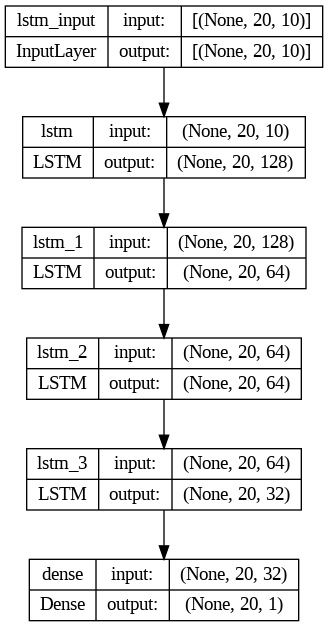

In [ ]:
K = tf.keras.backend

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = keras.Sequential()
# model.add(keras.layers.Flatten())
model.add(keras.layers.LSTM(128, activation="relu", input_shape=(20, 10), return_sequences=True))
model.add(keras.layers.LSTM(64, activation="relu", return_sequences=True))
model.add(keras.layers.LSTM(64, activation="relu", return_sequences=True))
model.add(keras.layers.LSTM(32, activation="relu", return_sequences=True))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1_score])

print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def dataframe_to_tensor(dataframe):
    dataframe = dataframe.copy()
    target = dataframe[:, :, 3]
    print(target.shape)
    dataframe = np.delete(dataframe, 3, axis=2)
    ds = tf.data.Dataset.from_tensor_slices((dataframe, target))
    return ds


_train = dataframe_to_tensor(train).batch(25)
_val = dataframe_to_tensor(val).batch(25)

print(_train.element_spec)
print(_val.element_spec)

(13330, 20)
(5713, 20)
(TensorSpec(shape=(None, 20, 10), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 20, 10), dtype=tf.float64, name=None), TensorSpec(shape=(None, 20), dtype=tf.float64, name=None))


In [ ]:
# tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

model.fit(
    _train,
    epochs=10,
    validation_data=_val,
    verbose=1,
)

model.save("/content/drive/MyDrive/Dataset/models/drowsiness_detection_v2_70_30")

Epoch 1/10
534/534 [==============================] - 63s 101ms/step - loss: 0.3129 - acc: 0.8168 - f1_score: 0.6594 - val_loss: 0.0615 - val_acc: 0.9865 - val_f1_score: 0.9859
Epoch 2/10
534/534 [==============================] - 51s 95ms/step - loss: 0.0606 - acc: 0.9868 - f1_score: 0.9861 - val_loss: 0.0567 - val_acc: 0.9873 - val_f1_score: 0.9866
Epoch 3/10
534/534 [==============================] - 50s 93ms/step - loss: 0.0585 - acc: 0.9870 - f1_score: 0.9863 - val_loss: 0.0564 - val_acc: 0.9873 - val_f1_score: 0.9867
Epoch 4/10
534/534 [==============================] - 50s 93ms/step - loss: 0.0578 - acc: 0.9871 - f1_score: 0.9865 - val_loss: 0.0560 - val_acc: 0.9874 - val_f1_score: 0.9868
Epoch 5/10
534/534 [==============================] - 53s 100ms/step - loss: 0.0573 - acc: 0.9873 - f1_score: 0.9867 - val_loss: 0.0556 - val_acc: 0.9876 - val_f1_score: 0.9870
Epoch 6/10
534/534 [==============================] - 51s 96ms/step - loss: 0.0570 - acc: 0.9873 - f1_score: 0.9867 - 

**Model V1 Evaluation and Results**

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/Dataset/models/drowsiness_detection_v1", custom_objects={'f1_score': f1_score})
import pandas as pd

states_test = [['glasses', glasses_test], ['noglasses', noglasses_test], ['night_noglasses', night_noglasses_test], ['sunglasses', sunglasses_test], ['nightglasses', nightglasses_test]]


def evaluate(model, test, state):
  data = dataframe_to_tensor(test).batch(25)

  score = model.evaluate(data, verbose=1)

  print(score)

  return {
      "State": state,
      "Loss": score[0],
      "Accuracy": score[1],
      "F1 Score": score[2]
  }

results = [ evaluate(model, x[1], x[0]) for x in states_test ]

# results = evaluate(model, glasses_data_test, 'glasses')

result_df = pd.DataFrame(results)

result_df.to_csv("/content/drive/MyDrive/Dataset/results/drowsiness_detection_v1_result.csv")

result_df

# results

(5345, 20)
214/214 [==============================] - 2s 9ms/step - loss: 0.0627 - acc: 0.9853 - f1_score: 0.9826
[0.06267676502466202, 0.9853041768074036, 0.9826368093490601]
(5312, 20)
213/213 [==============================] - 3s 12ms/step - loss: 0.0615 - acc: 0.9868 - f1_score: 0.9847
[0.061540160328149796, 0.9867560863494873, 0.9847102165222168]
(2620, 20)
105/105 [==============================] - 2s 15ms/step - loss: 0.0461 - acc: 0.9906 - f1_score: 0.9891
[0.04605522006750107, 0.9905725121498108, 0.9890943169593811]
(5401, 20)
217/217 [==============================] - 2s 9ms/step - loss: 0.0397 - acc: 0.9919 - f1_score: 0.9907
[0.03965425118803978, 0.991899847984314, 0.9906807541847229]
(2484, 20)
100/100 [==============================] - 1s 9ms/step - loss: 0.0481 - acc: 0.9902 - f1_score: 0.9884
[0.04810767248272896, 0.9901971220970154, 0.9883995056152344]


,State,Loss,Accuracy,F1 Score
0,glasses,0.062677,0.985304,0.982637
1,noglasses,0.061540,0.986756,0.984710
2,night_noglasses,0.046055,0.990573,0.989094
3,sunglasses,0.039654,0.991900,0.990681
4,nightglasses,0.048108,0.990197,0.988400


**Model V2 70_30 Evaluation and Results**

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/Dataset/models/drowsiness_detection_v2_70_30", custom_objects={'f1_score': f1_score})
import pandas as pd

states_test = [['glasses', glasses_test], ['noglasses', noglasses_test], ['night_noglasses', night_noglasses_test], ['sunglasses', sunglasses_test], ['nightglasses', nightglasses_test]]


def evaluate(model, test, state):
  data = dataframe_to_tensor(test).batch(25)

  score = model.evaluate(data, verbose=1)

  print(score)

  return {
      "State": state,
      "Loss": score[0],
      "Accuracy": score[1],
      "F1 Score": score[2]
  }

results = [ evaluate(model, x[1], x[0]) for x in states_test ]

result_df = pd.DataFrame(results)

result_df.to_csv("/content/drive/MyDrive/Dataset/results/drowsiness_detection_v2_70_30_result.csv")

result_df


(5345, 20)
214/214 [==============================] - 4s 14ms/step - loss: 0.0625 - acc: 0.9852 - f1_score: 0.9826
[0.062492407858371735, 0.9852479696273804, 0.9825656414031982]
(5312, 20)
213/213 [==============================] - 2s 9ms/step - loss: 0.0606 - acc: 0.9869 - f1_score: 0.9849
[0.06058235466480255, 0.9868785738945007, 0.9848524928092957]
(2620, 20)
105/105 [==============================] - 1s 9ms/step - loss: 0.0457 - acc: 0.9905 - f1_score: 0.9891
[0.04565388336777687, 0.9905344247817993, 0.9890624284744263]
(5401, 20)
217/217 [==============================] - 2s 9ms/step - loss: 0.0387 - acc: 0.9920 - f1_score: 0.9908
[0.038748085498809814, 0.9920294880867004, 0.9908333420753479]
(2484, 20)
100/100 [==============================] - 1s 9ms/step - loss: 0.0478 - acc: 0.9902 - f1_score: 0.9884
[0.04782278835773468, 0.9902374148368835, 0.9884455800056458]


,State,Loss,Accuracy,F1 Score
0,glasses,0.062492,0.985248,0.982566
1,noglasses,0.060582,0.986879,0.984852
2,night_noglasses,0.045654,0.990534,0.989062
3,sunglasses,0.038748,0.992029,0.990833
4,nightglasses,0.047823,0.990237,0.988446
